# Training Logistic Regression via Stochastic Gradient Ascent

The goal of this assignment is to implement a logistic regression classifier using stochastic gradient ascent. You will:

Extract features from Amazon product reviews.
Convert an SFrame into a NumPy array.
Write a function to compute the derivative of log likelihood function (with L2 penalty) with respect to a single coefficient.
Implement stochastic gradient ascent with L2 penalty
Compare convergence of stochastic gradient ascent with that of batch gradient ascent

In [1]:
import numpy as np
import pandas as pd
from sklearn import linear_model 

products = pd.read_csv('/Users/kevinwang/Documents/Coursera/Machine Learning - Classification/Week7/amazon_baby_subset.csv')  

## Load review dataset

For this assignment, we will use a subset of the Amazon product review dataset. The subset was chosen to contain similar numbers of positive and negative reviews, as the original dataset consisted primarily of positive reviews.

Load the dataset into a data frame named products. One column of this dataset is sentiment, corresponding to the class label with +1 indicating a review with positive sentiment and -1 for negative sentiment.

Let us quickly explore more of this dataset. The name column indicates the name of the product. Try listing the name of the first 10 products in the dataset.

After that, try counting the number of positive and negative reviews.

Note: For this assignment, we eliminated class imbalance by choosing a subset of the data with a similar number of positive and negative reviews.

In [2]:
print(products[0:10])
num_pos = sum(products['sentiment']==1)
num_neg = sum(products['sentiment']==-1)
print(num_pos)
print(num_neg)

                                                name  \
0  Stop Pacifier Sucking without tears with Thumb...   
1    Nature's Lullabies Second Year Sticker Calendar   
2    Nature's Lullabies Second Year Sticker Calendar   
3                        Lamaze Peekaboo, I Love You   
4  SoftPlay Peek-A-Boo Where's Elmo A Children's ...   
5                          Our Baby Girl Memory Book   
6  Hunnt&reg; Falling Flowers and Birds Kids Nurs...   
7  Blessed By Pope Benedict XVI Divine Mercy Full...   
8  Cloth Diaper Pins Stainless Steel Traditional ...   
9  Cloth Diaper Pins Stainless Steel Traditional ...   

                                              review  rating  sentiment  
0  All of my kids have cried non-stop when I trie...       5          1  
1  We wanted to get something to keep track of ou...       5          1  
2  My daughter had her 1st baby over a year ago. ...       5          1  
3  One of baby's first and favorite books, and it...       4          1  
4  Very cute 

## Apply text cleaning on the review data

In this section, we will perform some simple feature cleaning using data frames. The last assignment used all words in building bag-of-words features, but here we limit ourselves to 193 words (for simplicity). We compiled a list of 193 most frequent words into the JSON file named important_words.json. Load the words into a list important_words.

Let us perform 2 simple data transformations:

Remove punctuation
Compute word counts (only for important_words)
We start with the first item as follows:

If your tool supports it, fill n/a values in the review column with empty strings. The n/a values indicate empty reviews. For instance, Pandas's the fillna() method lets you replace all N/A's in the review columns as follows:

In [3]:
important_words = pd.read_json('/Users/kevinwang/Documents/Coursera/Machine Learning - Classification/Week7/important_words.json')
print(important_words)
#type(important_words)   #df
#print(important_words[0])
#type(important_words[0])   #series

          0
0      baby
1       one
2     great
3      love
4       use
..      ...
188  babies
189     won
190     tub
191  almost
192  either

[193 rows x 1 columns]


In [4]:
products = products.fillna({'review':''})  # fill empty string to replace N/A's in 'review' column

Write a function remove_punctuation that takes a line of text and removes all punctuation from that text. The function should be analogous to the following Python code:

In [5]:
def remove_punctuation(text):
    import string
    return text.translate(str.maketrans('','',string.punctuation))    # nature's will change to natures

Apply the remove_punctuation function on every element of the review column and assign the result to the new column review_clean. Note. Many data frame packages support apply operation for this type of task. Consult appropriate manuals.

In [6]:
products['review_clean'] = products['review'].apply(remove_punctuation)

Now we proceed with the second item. For each word in important_words, we compute a count for the number of times the word occurs in the review. We will store this count in a separate column (one for each word). The result of this feature processing is a single column for each word in important_words which keeps a count of the number of times the respective word occurs in the review text.

Note: There are several ways of doing this. One way is to create an anonymous function that counts the occurrence of a particular word and apply it to every element in the review_clean column. Repeat this step for every word in important_words. Your code should be analogous to the following:

In [7]:
for word in important_words[0]:
    products[word] = products['review_clean'].apply(lambda s : s.split().count(word))

The data frame products should contain one column for each of the 193 important_words. As an example, the column perfect contains a count of the number of times the word perfect occurs in each of the reviews.

Now, write some code to compute the number of product reviews that contain the word 'perfect'.

Hint:

First create a column called 'contains_perfect' which is set to 1 if the count of the word perfect (stored in column perfect is >= 1.
Sum the number of 1s in the column contains_perfect.

In [8]:
products['countains_perfect'] = products['perfect'].apply(lambda x : 1 if x >= 1 else 0)
#print(products['countains_perfect'])
sum(products['countains_perfect'])      #2955

2955

Quiz Question. How many reviews contain the word perfect?

Answer: 2955

In [9]:
import json
with open('/Users/kevinwang/Documents/Coursera/Machine Learning - Classification/Week7/module-10-assignment-train-idx.json', 'r') as f: # Reads the list of most frequent words
    train_idx = json.load(f)
with open('/Users/kevinwang/Documents/Coursera/Machine Learning - Classification/Week7/module-10-assignment-validation-idx.json', 'r') as f1: # Reads the list of most frequent words
    validation_idx = json.load(f1)
    
train_data = products.iloc[train_idx]
validation_data = products.iloc[validation_idx]
print(train_data.shape)

(47780, 199)


## Convert data frame to multi-dimensional array

It is now time to convert our data frame to a multi-dimensional array. Look for a package that provides a highly optimized matrix operations. In the case of Python, NumPy is a good choice.

Write a function that extracts columns from a data frame and converts them into a multi-dimensional array. We plan to use them throughout the course, so make sure to get this function right.

The function should accept three parameters:

dataframe: a data frame to be converted
features: a list of string, containing the names of the columns that are used as features.
label: a string, containing the name of the single column that is used as class labels.
The function should return two values:

one 2D array for features
one 1D array for class labels
The function should do the following:

Prepend a new column constant to dataframe and fill it with 1's. This column takes account of the intercept term. Make sure that the constant column appears first in the data frame.
Prepend a string 'constant' to the list features. Make sure the string 'constant' appears first in the list.
Extract columns in dataframe whose names appear in the list features.
Convert the extracted columns into a 2D array using a function in the data frame library. If you are using Pandas, you would use as_matrix() function.
Extract the single column in dataframe whose name corresponds to the string label.
Convert the column into a 1D array.
Return the 2D array and the 1D array.

In [11]:
def get_numpy_data(dataframe, features, label):
    dataframe['constant'] = 1
    features = ['constant'] + features
    features_frame = dataframe[features]
    feature_matrix = features_frame.as_matrix()
    label_sarray = dataframe[label]
    label_array = label_sarray.as_matrix()
    return(feature_matrix, label_array)

Using the function written, extract two arrays feature_matrix and sentiment. The 2D array feature_matrix would contain the content of the columns given by the list important_words. The 1D array sentiment would contain the content of the column sentiment.

Quiz Question: How many features are there in the feature_matrix?

Answer: 194

Quiz Question: Assuming that the intercept is present, how does the number of features in feature_matrix relate to the number of features in the logistic regression model?

In [12]:
feature_matrix_train, sentiment_train = get_numpy_data(train_data, list(important_words[0]), 'sentiment')
feature_matrix_valid, sentiment_valid = get_numpy_data(validation_data, list(important_words[0]), 'sentiment')

/Users/kevinwang/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/kevinwang/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """
/Users/kevinwang/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  import sys


Quiz question: In Module 3 assignment, there were 194 features (an intercept + one feature for each of the 193 important words). In this assignment, we will use stochastic gradient ascent to train the classifier using logistic regression. How does the changing the solver to stochastic gradient ascent affect the number of features?

Answer: The same

## Building on logistic regression

h(xi) is given by the word counts of important_words in the review xi

We will use the same code as in Module 3 assignment to make probability predictions, since this part is not affected by using stochastic gradient ascent as a solver. Only the way in which the coefficients are learned is affected by using stochastic gradient ascent as a solver. Refer to #10 of Module 3 assignment in order to obtain the function predict_probability.

In [14]:
'''
produces probablistic estimate for P(y_i = +1 | x_i, w).
estimate ranges between 0 and 1.
'''
def predict_probability(feature_matrix, coefficients):
    # Take dot product of feature_matrix and coefficients  
    # YOUR CODE HERE
    score = np.dot(feature_matrix, coefficients)
    
    # Compute P(y_i = +1 | x_i, w) using the link function
    # YOUR CODE HERE
    predictions = 1/(1+np.exp(-score))
    
    # return predictions
    return predictions

## Derivative of log likelihood with respect to a single coefficient

Recall that, in the Module 3 assignment, we wrote the function feature_derivative to compute the derivative of log likelihood with respect to a single coefficient wj 
	
Refer to #11 of Module 3 assignment to obtain the function feature_derivative.

Note. We are not using regularization in this assignment, but, as discussed in the optional video, stochastic gradient can also be used for regularized logistic regression.

In [15]:
def feature_derivative(errors, feature):       #derivative of log likelihood  
    # Compute the dot product of errors and feature
    derivative = np.dot(errors, feature)    #errors => (1,n)  features => (n, m)    derivative => (1,m)
        # Return the derivative
    return derivative

To verify the correctness of the gradient computation, we provide a function for computing average log likelihood (which we recall from the last assignment was a topic detailed in an advanced optional video, and used here for its numerical stability).

To track the performance of stochastic gradient ascent, write yourself a function to compute average log likelihood. The average log likelihood is given by the formula

Call this function compute_avg_log_likelihood. It should be analogous to the following Python function:

In [20]:
def compute_avg_log_likelihood(feature_matrix, sentiment, coefficients):     #avg_log_likelihood

    indicator = (sentiment==+1)
    scores = np.dot(feature_matrix, coefficients)
    logexp = np.log(1. + np.exp(-scores))
    
    # Simple check to prevent overflow
    mask = np.isinf(logexp)
    logexp[mask] = -scores[mask]   
    
    lp = np.sum((indicator-1)*scores - logexp)/len(feature_matrix)   
    
    return lp  

Note. We made one tiny modification to the log likelihood function (called compute_log_likelihood) in our earlier assignments. We added a 1/N term which averages the log likelihood accross all data points. The 1/N term makes it easier for us to compare stochastic gradient ascent with batch gradient ascent. We will use this function to generate plots that are similar to those you saw in the lecture.

In [21]:
def compute_log_likelihood(feature_matrix, sentiment, coefficients):  #log_likelihood (= avg_log_likelihood * N)
    indicator = (sentiment==+1)
    scores = np.dot(feature_matrix, coefficients)    #(n,1)
    lp = np.sum((indicator-1)*scores - np.log(1. + np.exp(-scores)))    #(1,1)
    return lp    

Quiz question: Recall from the lecture and the earlier assignment, we have the log likelihood (without the averaging term).
How are the functions 'compute_avg_log_likelihood' and 'compute_log_likelihood' related:

Answer: 

log_likelihood = avg_log_likelihood * N   
compute_log_likelihood = compute_avg_log_likelihood * N

## Modifying the derivative for stochastic gradient ascent

Recall from the lecture that the gradient for a single data point x_i can be computed using the following formula:

### Computing the gradient for a single data point i 

i is data point i, j is feature j

Do we really need to re-write all our code to modify ∂l(w)/∂wj to ∂li(w)/∂wj

meaning modify gradient for all points with respect to feature j, to gradient of one points i with respect to feature j 

Thankfully No! We access 
  
We access data point xi in the training data using feature_matrix_train[i:i+1,:]

Similarly, we access data point yi in the training data using sentiment_train[i:i+1]

We can compute ∂li(w)/∂wj by re-using all the code written in feature_derivative and predict_probability.

1. First, compute p(yi=1|xi, w) using the predict_probability function with feature_matrix_train[i:i+1,:] as the first parameter.

2. Next, compute the indicator value 1[yi=+1] using sentiment_train[i:i+1].
3. Finally, call the feature_derivative function with feature_matrix_train[i:i+1,j] as one of the parameters

The following Python cell carries out the steps for j=1 and i=10. (Try this in your own tool.)

In [24]:
j = 1                        # j-th Feature number
i = 10                       # i-th Data point 
coefficients = np.zeros(194) # A point w at which we are computing the gradient.

predictions = predict_probability(feature_matrix_train[i:i+1,:], coefficients)
print (predictions)
indicator = (sentiment_train[i:i+1]==+1)
print(predictions)
errors = indicator - predictions
print(errors)
gradient_single_data_point = feature_derivative(errors, feature_matrix_train[i:i+1,j])
print("Gradient single data point: %s" % gradient_single_data_point)
print("           --> Should print 0.0")

[0.5]
[0.5]
[0.5]
Gradient single data point: 0.0
           --> Should print 0.0


Quiz Question: The code block above computed the derivative ∂li(w)/∂wj for j = 1 and i = 10. Is ∂li(w)/∂wj a scalar or a 194-dimensional vector?

Answer:Scalar

## Modifying the derivative for using a batch of data points

Stochastic gradient estimates the ascent direction using 1 data point, while gradient uses N data points to decide how to update the the parameters. In an optional video, we discussed the details of a simple change that allows us to use a mini-batch of B<=N data points to estimate the ascent direction. This simple approach is faster than regular gradient but less noisy than stochastic gradient that uses only 1 data point. Although we encorage you to watch the optional video on the topic to better understand why mini-batches help stochastic gradient, in this assignment, we will simply use this technique, since the approach is very simple and will improve your results.

### Computing the gradient for a "mini-batch" of data points

Given a mini-batch (or a set of data points, B numbers of points) 
x_i, x_i+1,..., x_i+B, the gradient function for this mini-batch of data points is given by:

=> It is the sum of single point gradient that we just calcualted.  Sum of B points

In [27]:
j = 1                        # j-th Feature number
i = 10                       # i-th Data point 
B = 10                       # Mini-batch size, each batch has 10 points
coefficients = np.zeros(194) # A point w at which we are computing the gradient.

predictions = predict_probability(feature_matrix_train[i:i+B,:], coefficients)
print (predictions)
indicator = (sentiment_train[i:i+B]==+1)
print(predictions)
errors = indicator - predictions
print(errors)
gradient_mini_batch = feature_derivative(errors, feature_matrix_train[i:i+B,j])
print("Gradient mini-batch data points: %s" % gradient_mini_batch)
print("           --> Should print 1.0")

[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5]
[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5]
[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5]
Gradient single data point: 1.0
           --> Should print 1.0


Quiz Question: The code block above computed the sum of B points of derivative ∂li(w)/∂wj for j = 10, i = 10, and B = 10. Is this a scalar or a 194-dimensional vector?

Answer:Scalar

Quiz Question: For what value of B is the term => sum of B points of derivative ∂li(w)/∂wj, the same as the full gradient ∂l(w)/∂wj

Answer: when B = number of data points (N)

## Averaging the gradient across a batch
  
It is a common practice to normalize the gradient update rule by the batch size B:  (Divided the thing we just calculated by B)

∂l_avg_(w)/∂wj

In other words, we update the coefficients using the average gradient over data points (instead of using a summation). By using the average gradient, we ensure that the magnitude of the gradient is approximately the same for all batch sizes. This way, we can more easily compare various batch sizes of stochastic gradient ascent (including a batch size of all the data points), and study the effect of batch size on the algorithm as well as the choice of step size.

## Implementing stochastic gradient ascent

Now we are ready to implement our own logistic regression with stochastic gradient ascent. The function logistic_regression_SG should accept the following parameters:

feature_matrix: 2D array of features
sentiment: 1D array of class labels
initial_coefficients: 1D array containing initial values of coefficients
step_size: a parameter controlling the size of the gradient steps
batch_size: size of mini-batch
max_iter: number of iterations to run stochastic gradient ascent
The function should return the final set of coefficients, along with the list of log likelihood values over time. (In practice, the final set of coefficients is rarely used; it is better to use the average of the last K sets of coefficients instead, where K should be adjusted depending on how fast the log likelihood oscillates around the optimum.)

The function logistic_regression_SG carries out the steps shown in the following pseudocode:

* Create an empty list called log_likelihood_all
* Initialize coefficients to initial_coefficients
* Set random seed = 1
* Shuffle the data before starting the loop below
* Set i = 0, the index of current batch

* Run the following steps max_iter times, performing linear scans over the data:
  * Predict P(y_i = +1|x_i,w) using your predict_probability() function
    Make sure to slice the i-th row of feature_matrix with [i:i+batch_size,:]
  * Compute indicator value for (y_i = +1)
    Make sure to slice the i-th entry with [i:i+batch_size]
  * Compute the errors as (indicator - predictions)
  * For each coefficients[j]:
    - Compute the derivative for coefficients[j] and save it to derivative.
      Make sure to slice the i-th row of feature_matrix with [i:i+batch_size,j]
    - Compute the product of the step size, the derivative, and (1./batch_size).
    - Increment coefficients[j] by the product just computed.
  * Compute the average log likelihood over the current batch.
    Add this value to the list log_likelihood_all.
  * Increment i by batch_size, indicating the progress made so far on the data.
  * Check whether we made a complete pass over data by checking
    whether (i+batch_size) exceeds the data size. If so, shuffle the data. If not, do nothing.

* Return the final set of coefficients, along with the list log_likelihood_all.

In [30]:
def logistic_regression_SG(feature_matrix, sentiment, initial_coefficients, step_size, batch_size, max_iter):
    log_likelihood_all = []

    # make sure it's a numpy array
    coefficients = np.array(initial_coefficients)
    # set seed=1 to produce consistent results
    np.random.seed(seed=1)
    # Shuffle the data before starting
    permutation = np.random.permutation(len(feature_matrix))
    feature_matrix = feature_matrix[permutation,:]
    sentiment = sentiment[permutation]

    i = 0 # index of current batch;  Start from point i = 0
    # Do a linear scan over data
    for itr in range(max_iter):       # one iteration means one step, using one batch, 
        # Predict P(y_i = +1|x_i,w) using your predict_probability() function
        # Make sure to slice the i-th row of feature_matrix with [i:i+batch_size,:]
        ### YOUR CODE HERE
        predictions = predict_probability(feature_matrix[i:i+batch_size,:], coefficients)   #batch size * 1

        # Compute indicator value for (y_i = +1)
        # Make sure to slice the i-th entry with [i:i+batch_size]
        ### YOUR CODE HERE
        indicator = (sentiment[i:i+batch_size] == +1)     #batch size * 1

        # Compute the errors as indicator - predictions
        errors = indicator - predictions                 #batch size * 1
        for j in range(len(coefficients)): # loop over each coefficient
            # Recall that feature_matrix[:,j] is the feature column associated with coefficients[j]
            # Compute the derivative for coefficients[j] and save it to derivative.
            # Make sure to slice the i-th row of feature_matrix with [i:i+batch_size,j]    
            ### YOUR CODE HERE
            derivative = feature_derivative(errors, feature_matrix[i:i+batch_size,j])       # 1*1 
            # Compute the product of the step size, the derivative, and
            # the **normalization constant** (1./batch_size)
            ### YOUR CODE HERE
            coefficients[j] += step_size * derivative * 1./batch_size    # 1*1

        # Checking whether log likelihood is increasing
        # Print the log likelihood over the *current batch*
        lp = compute_avg_log_likelihood(feature_matrix[i:i+batch_size,:], sentiment[i:i+batch_size],
                                        coefficients)
        log_likelihood_all.append(lp)
        if itr <= 15 or (itr <= 1000 and itr % 100 == 0) or (itr <= 10000 and itr % 1000 == 0) \
         or itr % 10000 == 0 or itr == max_iter-1:
            data_size = len(feature_matrix)
            print('Iteration %*d: Average log likelihood (of data points  [%0*d:%0*d]) = %.8f' % \
                (int(np.ceil(np.log10(max_iter))), itr, \
                 int(np.ceil(np.log10(data_size))), i, \
                 int(np.ceil(np.log10(data_size))), i+batch_size, lp))

        # if we made a complete pass over data, shuffle and restart
        i += batch_size       
        if i+batch_size > len(feature_matrix):
            permutation = np.random.permutation(len(feature_matrix))
            feature_matrix = feature_matrix[permutation,:]
            sentiment = sentiment[permutation]
            i = 0             # back to Start from point i = 0        

    # We return the list of log likelihoods for plotting purposes.
    return coefficients, log_likelihood_all

## Compare convergence behavior of stochastic gradient ascent

For the remainder of the assignment, we will compare stochastic gradient ascent against batch gradient ascent. For this, we need a reference implementation of batch gradient ascent. But do we need to implement this from scratch?

Quiz Question: For what value of batch size B above is the stochastic gradient ascent function logistic_regression_SG act as a standard gradient ascent algorithm?

Answer: B = number of data (N) = 47780

# 1. Stochastic Gradient Descent

## Running gradient ascent using the stochastic gradient ascent implementation

Instead of implementing batch gradient ascent separately, we save time by re-using the stochastic gradient ascent function we just wrote — to perform gradient ascent, it suffices to set batch_size to the number of data points in the training data. Yes, we did answer above the quiz question for you, but that is an important point to remember in the future :)

Small Caveat. The batch gradient ascent implementation here is slightly different than the one in the earlier assignments, as we now normalize the gradient update rule.

We now run stochastic gradient ascent over the feature_matrix_train for 10 iterations using:

initial_coefficients = np.zeros(194)
step_size = 5e-1
batch_size = 1
max_iter = 10


In [35]:
# 1. stochastic gradient descent (batch size = 1) 
# Max iteration = 10, meaning max steps are 10 steps

initial_coefficients = np.zeros(194)
step_size = 5e-1
batch_size = 1
max_iter = 10
feature_matrix = feature_matrix_train
sentiment = sentiment_train

In [48]:
coefficients_stochast, log_likelihood_stochast = logistic_regression_SG(feature_matrix, sentiment, initial_coefficients=np.zeros(194), step_size=5e-1, batch_size=1, max_iter=10)

Iteration 0: Average log likelihood (of data points  [00000:00001]) = -0.25192908
Iteration 1: Average log likelihood (of data points  [00001:00002]) = -0.00000001
Iteration 2: Average log likelihood (of data points  [00002:00003]) = -0.12692771
Iteration 3: Average log likelihood (of data points  [00003:00004]) = -0.02969101
Iteration 4: Average log likelihood (of data points  [00004:00005]) = -0.02668819
Iteration 5: Average log likelihood (of data points  [00005:00006]) = -0.04332901
Iteration 6: Average log likelihood (of data points  [00006:00007]) = -0.02368802
Iteration 7: Average log likelihood (of data points  [00007:00008]) = -0.12686897
Iteration 8: Average log likelihood (of data points  [00008:00009]) = -0.04468879
Iteration 9: Average log likelihood (of data points  [00009:00010]) = -0.00000124


Quiz Question. When you set batch_size = 1, as each iteration passes, how does the average log likelihood in the batch change?

Answer: Goes up and down, not monotone.  Fluctuate

# 2. Batch Gradient Descent

Now run batch gradient ascent over the feature_matrix_train for 200 iterations using:

initial_coefficients = np.zeros(194)
step_size = 5e-1
batch_size = number of rows in feature_matrix_train
max_iter = 200

In [37]:
# 2. Batch gradient descent (batch size = N) 
# Max iteration = 200, meaning max steps are 200 steps

initial_coefficients = np.zeros(194)
step_size = 5e-1
batch_size = len(sentiment_train)
max_iter = 200
feature_matrix = feature_matrix_train
sentiment = sentiment_train

In [38]:
coefficients_batch, log_likelihood_batch = logistic_regression_SG(feature_matrix, sentiment, initial_coefficients=np.zeros(194), step_size=5e-1, batch_size=len(sentiment_train), max_iter=200)

Iteration   0: Average log likelihood (of data points  [00000:47780]) = -0.68308119
Iteration   1: Average log likelihood (of data points  [00000:47780]) = -0.67394599
Iteration   2: Average log likelihood (of data points  [00000:47780]) = -0.66555129
Iteration   3: Average log likelihood (of data points  [00000:47780]) = -0.65779626
Iteration   4: Average log likelihood (of data points  [00000:47780]) = -0.65060701
Iteration   5: Average log likelihood (of data points  [00000:47780]) = -0.64392241
Iteration   6: Average log likelihood (of data points  [00000:47780]) = -0.63769009
Iteration   7: Average log likelihood (of data points  [00000:47780]) = -0.63186462
Iteration   8: Average log likelihood (of data points  [00000:47780]) = -0.62640636
Iteration   9: Average log likelihood (of data points  [00000:47780]) = -0.62128063
Iteration  10: Average log likelihood (of data points  [00000:47780]) = -0.61645691
Iteration  11: Average log likelihood (of data points  [00000:47780]) = -0.6

Quiz Question. When you set batch_size = len(train_data), as each iteration passes, how does the average log likelihood in the batch change?

Answer: Increasing

# 3. Mini-Batch Gradient Descent

## Make "passes" over the dataset

To make a fair comparison betweeen stochastic gradient ascent and batch gradient ascent, we measure the average log likelihood as a function of the number of passes (defined as follows):

[# of passes]=[# of data points touched so far] / [Number of data points N]

Quiz Question: Suppose that we run stochastic gradient ascent with a batch size of 100. How many gradient updates are performed at the end of two passes over a dataset consisting of 50000 data points?

Answer: Iteration = 50000*2 / 100 = 1000

## Log likelihood plots for stochastic gradient ascent

With the terminology in mind, let us run stochastic gradient ascent for 10 passes. We will use

step_size=1e-1
batch_size=100
initial_coefficients set to all zeros = np.zeros(194)
feature_matrix = feature_matrix_train
sentiment = sentiment_train

In [73]:
# 3. Mini-Batch gradient descent (batch size = 100, in range of 1 to N) 
# Because we want 10 pass; so max_iter = (N/batch size) * 10

pass_num = 10
step_size=1e-1
batch_size=100
initial_coefficients = np.zeros(194)
feature_matrix = feature_matrix_train
sentiment = sentiment_train
max_iter = int(len(sentiment_train)/batch_size) * pass_num  #Because we want 10 pass; 1 iteration means 1 step;
len(sentiment_train)

47780

In [46]:
coefficients_mini_batch, log_likelihood_mini_batch = logistic_regression_SG(feature_matrix, sentiment, initial_coefficients=np.zeros(194), step_size=1e-1, batch_size=100, max_iter=max_iter)

Iteration    0: Average log likelihood (of data points  [00000:00100]) = -0.68251093
Iteration    1: Average log likelihood (of data points  [00100:00200]) = -0.67845294
Iteration    2: Average log likelihood (of data points  [00200:00300]) = -0.68207160
Iteration    3: Average log likelihood (of data points  [00300:00400]) = -0.67411325
Iteration    4: Average log likelihood (of data points  [00400:00500]) = -0.67804438
Iteration    5: Average log likelihood (of data points  [00500:00600]) = -0.67712546
Iteration    6: Average log likelihood (of data points  [00600:00700]) = -0.66377074
Iteration    7: Average log likelihood (of data points  [00700:00800]) = -0.67321231
Iteration    8: Average log likelihood (of data points  [00800:00900]) = -0.66923613
Iteration    9: Average log likelihood (of data points  [00900:01000]) = -0.67479446
Iteration   10: Average log likelihood (of data points  [01000:01100]) = -0.66501639
Iteration   11: Average log likelihood (of data points  [01100:01

Write yourself a function to generate a plot of the average log likelihood as a function of the number of passes. The function should accept the following parameters:

1. log_likelihood_all, the list of average log likelihood over time
2. len_data, number of data points in the training set
3. batch_size, size of each mini-batch
4. smoothing_window, a parameter for computing moving averages

The function should first compute moving averages of log_likelihood_all. To do this efficiently, convolve log_likelihood_all with the vector of length smoothing_window that is filled with the value 1/smoothing_window.

The function then plot the moving averages over the number of passes over the data. Use len_data and batch_size to convert iteration number of (fractional) number of passes.

Using matplotlib, the plot-making function would be as follows:

In [69]:
import matplotlib.pyplot as plt
%matplotlib inline

def make_plot(log_likelihood_all, len_data, batch_size, smoothing_window=1, label=''):
    plt.rcParams.update({'figure.figsize': (9,5)})
    log_likelihood_all_ma = np.convolve(np.array(log_likelihood_all), \
                                        np.ones((smoothing_window,))/smoothing_window, mode='valid')

    plt.plot(np.array(range(smoothing_window-1, len(log_likelihood_all)))*float(batch_size)/len_data,
             log_likelihood_all_ma, linewidth=4.0, label=label)
    plt.rcParams.update({'font.size': 16})
    plt.tight_layout()
    plt.xlabel('# of passes over data')
    plt.ylabel('Average log likelihood per data point')
    plt.legend(loc='lower right', prop={'size':14})
    plt.show()

No handles with labels found to put in legend.


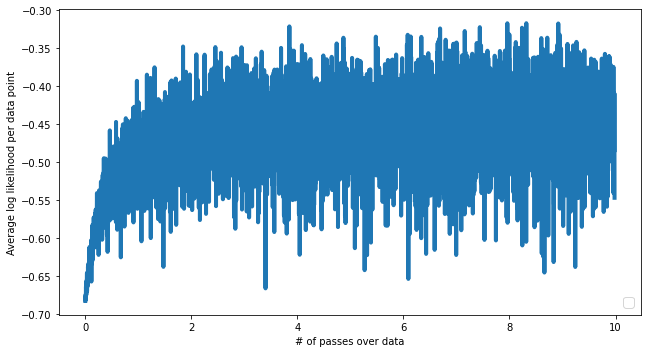

In [70]:
# 3. mini-batch plot 
# smooth window = 1
make_plot(log_likelihood_mini_batch, len(feature_matrix_train), batch_size, smoothing_window=1, label='')

No handles with labels found to put in legend.


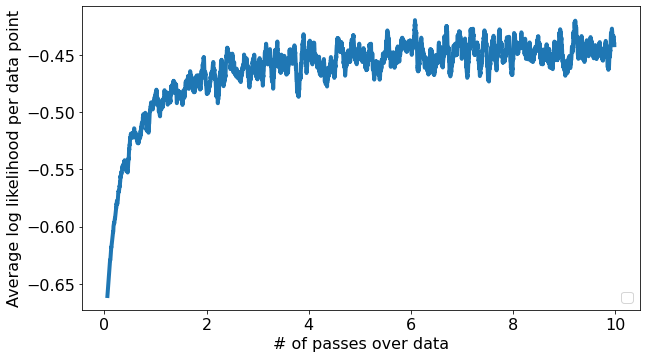

In [52]:
# 3. mini-batch plot 
# smooth window = 30
make_plot(log_likelihood_mini_batch, len(feature_matrix_train), batch_size, smoothing_window=30, label='')

## Mini-Batch (Stochastic) gradient ascent vs batch gradient ascent

To compare convergence rates for stochastic gradient ascent with batch gradient ascent, we call make_plot() multiple times.

We are comparing:

(4) 
mini-batch (stochastic) gradient ascent: step_size = 0.1, batch_size=100.  initial_coefficients set to all zeros.
Write code to run stochastic gradient ascent for 200 passes.   (It is different from 3, because different # passes)

(2)
batch gradient ascent: step_size = 0.5, batch_size=[# rows in feature_matrix_train].  That's the same as above.
For batch gradient ascent, use the results obtained from above.

In [58]:
# 4. Mini-batch (stochastic) gradient descent (batch size = 100) 
# It is different from 3, because of different # passes
# Because we want 200 pass; so max_iter = (N/batch size) * 200

pass_num = 200
step_size=1e-1
batch_size=100
initial_coefficients = np.zeros(194)
feature_matrix = feature_matrix_train
sentiment = sentiment_train
max_iter = int(len(sentiment_train)/batch_size) * pass_num  #Because we want 200 pass; 1 iteration means 1 step;
print(max_iter)
#len(sentiment_train)

95400


In [59]:
coefficients_mini_batch2, log_likelihood_mini_batch2 = logistic_regression_SG(feature_matrix, sentiment, initial_coefficients=np.zeros(194), step_size=1e-1, batch_size=100, max_iter=max_iter)

Iteration     0: Average log likelihood (of data points  [00000:00100]) = -0.68251093
Iteration     1: Average log likelihood (of data points  [00100:00200]) = -0.67845294
Iteration     2: Average log likelihood (of data points  [00200:00300]) = -0.68207160
Iteration     3: Average log likelihood (of data points  [00300:00400]) = -0.67411325
Iteration     4: Average log likelihood (of data points  [00400:00500]) = -0.67804438
Iteration     5: Average log likelihood (of data points  [00500:00600]) = -0.67712546
Iteration     6: Average log likelihood (of data points  [00600:00700]) = -0.66377074
Iteration     7: Average log likelihood (of data points  [00700:00800]) = -0.67321231
Iteration     8: Average log likelihood (of data points  [00800:00900]) = -0.66923613
Iteration     9: Average log likelihood (of data points  [00900:01000]) = -0.67479446
Iteration    10: Average log likelihood (of data points  [01000:01100]) = -0.66501639
Iteration    11: Average log likelihood (of data point

We compare the convergence of mini-batch (stochastic) gradient ascent and batch gradient ascent by calling the make_plot function. Apply smoothing with smoothing_window=30.

No handles with labels found to put in legend.


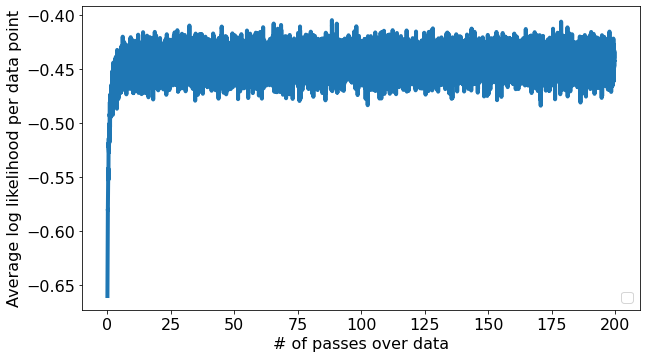

In [60]:
# 4. Mini-batch (stochastic) gradient descent (batch size = 100)
make_plot(log_likelihood_mini_batch2, len(feature_matrix_train), batch_size, smoothing_window=30, label='')

In [ ]:
# 2. Batch gradient descent (batch size = N)
make_plot(log_likelihood_batch, len(feature_matrix_train), batch_size = len(sentiment_train), smoothing_window=30, label='')

Quiz Question: In the figure above, how many passes does batch gradient ascent need to achieve a similar log likelihood as stochastic gradient ascent?

Answer: 200 passes

## Explore the effects of step sizes on stochastic gradient ascent

In previous sections, we chose step sizes for you. In practice, it helps to know how to choose good step sizes yourself.

To start, we explore a wide range of step sizes that are equally spaced in the log space. Run stochastic gradient ascent with step_size set to 1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, and 1e2. Use

initial_coefficients=np.zeros(194)
batch_size=100
max_iter initialized so as to run 10 passes over the data.

## Plotting the log likelihood as a function of passes for each step size

Now, we will plot the change in log likelihood using the make_plot for each of the following values of step_size:

step_size = 1e-4
step_size = 1e-3
step_size = 1e-2
step_size = 1e-1
step_size = 1e0
step_size = 1e1
step_size = 1e2
For consistency, use smoothing_window=30.

In [64]:
# 5. Mini-batch (stochastic) gradient descent (different step size) 
# It is different from 3 and 4, because of different # passes and step size
# Because we want 10 pass; so max_iter = (N/batch size) * 10

pass_num = 10
batch_size=100
initial_coefficients = np.zeros(194)
feature_matrix = feature_matrix_train
sentiment = sentiment_train
max_iter = int(len(sentiment_train)/batch_size) * pass_num 

step_size = 0.0001
Iteration    0: Average log likelihood (of data points  [00000:00100]) = -0.69313622
Iteration    1: Average log likelihood (of data points  [00100:00200]) = -0.69313170
Iteration    2: Average log likelihood (of data points  [00200:00300]) = -0.69313585
Iteration    3: Average log likelihood (of data points  [00300:00400]) = -0.69312487
Iteration    4: Average log likelihood (of data points  [00400:00500]) = -0.69313157
Iteration    5: Average log likelihood (of data points  [00500:00600]) = -0.69313113
Iteration    6: Average log likelihood (of data points  [00600:00700]) = -0.69311121
Iteration    7: Average log likelihood (of data points  [00700:00800]) = -0.69312692
Iteration    8: Average log likelihood (of data points  [00800:00900]) = -0.69312115
Iteration    9: Average log likelihood (of data points  [00900:01000]) = -0.69312811
Iteration   10: Average log likelihood (of data points  [01000:01100]) = -0.69311286
Iteration   11: Average log likelihood (of dat

No handles with labels found to put in legend.


Iteration 4769: Average log likelihood (of data points  [47600:47700]) = -0.68736824


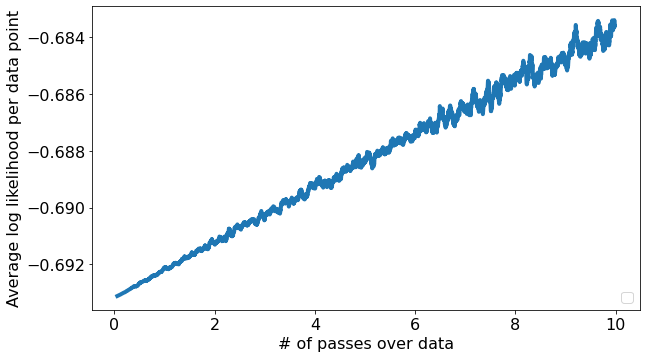

step_size = 0.001
Iteration    0: Average log likelihood (of data points  [00000:00100]) = -0.69303759
Iteration    1: Average log likelihood (of data points  [00100:00200]) = -0.69299241
Iteration    2: Average log likelihood (of data points  [00200:00300]) = -0.69303389
Iteration    3: Average log likelihood (of data points  [00300:00400]) = -0.69292442
Iteration    4: Average log likelihood (of data points  [00400:00500]) = -0.69299113
Iteration    5: Average log likelihood (of data points  [00500:00600]) = -0.69298668
Iteration    6: Average log likelihood (of data points  [00600:00700]) = -0.69278828
Iteration    7: Average log likelihood (of data points  [00700:00800]) = -0.69294460
Iteration    8: Average log likelihood (of data points  [00800:00900]) = -0.69288708
Iteration    9: Average log likelihood (of data points  [00900:01000]) = -0.69295651
Iteration   10: Average log likelihood (of data points  [01000:01100]) = -0.69280480
Iteration   11: Average log likelihood (of data

No handles with labels found to put in legend.


Iteration 4769: Average log likelihood (of data points  [47600:47700]) = -0.64571292


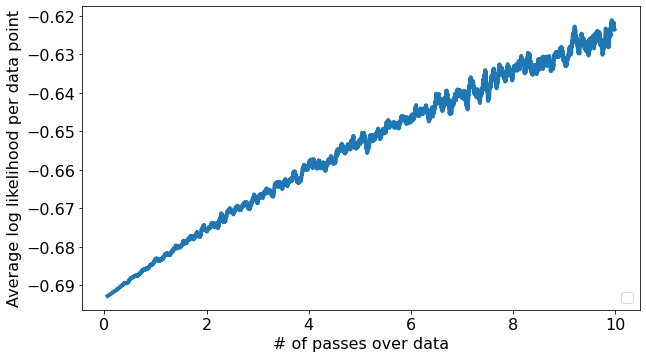

step_size = 0.01
Iteration    0: Average log likelihood (of data points  [00000:00100]) = -0.69205420
Iteration    1: Average log likelihood (of data points  [00100:00200]) = -0.69160695
Iteration    2: Average log likelihood (of data points  [00200:00300]) = -0.69201686
Iteration    3: Average log likelihood (of data points  [00300:00400]) = -0.69095428
Iteration    4: Average log likelihood (of data points  [00400:00500]) = -0.69159348
Iteration    5: Average log likelihood (of data points  [00500:00600]) = -0.69154386
Iteration    6: Average log likelihood (of data points  [00600:00700]) = -0.68964000
Iteration    7: Average log likelihood (of data points  [00700:00800]) = -0.69112685
Iteration    8: Average log likelihood (of data points  [00800:00900]) = -0.69056997
Iteration    9: Average log likelihood (of data points  [00900:01000]) = -0.69124730
Iteration   10: Average log likelihood (of data points  [01000:01100]) = -0.68980179
Iteration   11: Average log likelihood (of data 

No handles with labels found to put in legend.


Iteration 4769: Average log likelihood (of data points  [47600:47700]) = -0.56306510


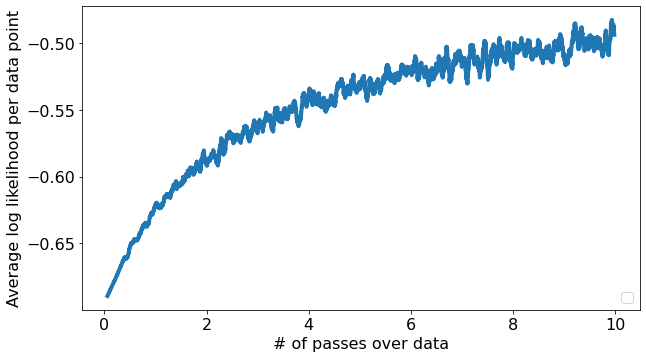

step_size = 0.1
Iteration    0: Average log likelihood (of data points  [00000:00100]) = -0.68251093
Iteration    1: Average log likelihood (of data points  [00100:00200]) = -0.67845294
Iteration    2: Average log likelihood (of data points  [00200:00300]) = -0.68207160
Iteration    3: Average log likelihood (of data points  [00300:00400]) = -0.67411325
Iteration    4: Average log likelihood (of data points  [00400:00500]) = -0.67804438
Iteration    5: Average log likelihood (of data points  [00500:00600]) = -0.67712546
Iteration    6: Average log likelihood (of data points  [00600:00700]) = -0.66377074
Iteration    7: Average log likelihood (of data points  [00700:00800]) = -0.67321231
Iteration    8: Average log likelihood (of data points  [00800:00900]) = -0.66923613
Iteration    9: Average log likelihood (of data points  [00900:01000]) = -0.67479446
Iteration   10: Average log likelihood (of data points  [01000:01100]) = -0.66501639
Iteration   11: Average log likelihood (of data p

No handles with labels found to put in legend.


Iteration 4769: Average log likelihood (of data points  [47600:47700]) = -0.54670667


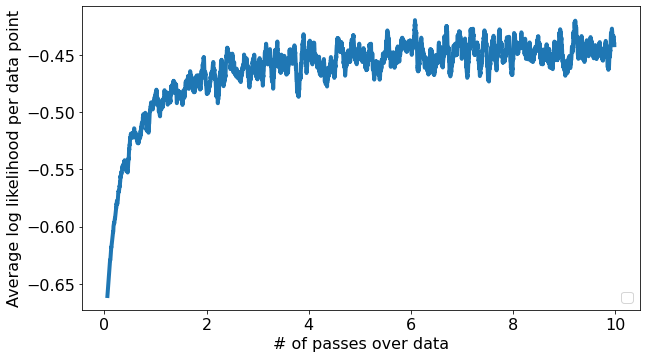

step_size = 1.0
Iteration    0: Average log likelihood (of data points  [00000:00100]) = -0.61201447
Iteration    1: Average log likelihood (of data points  [00100:00200]) = -0.58843678
Iteration    2: Average log likelihood (of data points  [00200:00300]) = -0.59771677
Iteration    3: Average log likelihood (of data points  [00300:00400]) = -0.58770466
Iteration    4: Average log likelihood (of data points  [00400:00500]) = -0.56939710
Iteration    5: Average log likelihood (of data points  [00500:00600]) = -0.57554451
Iteration    6: Average log likelihood (of data points  [00600:00700]) = -0.54068090
Iteration    7: Average log likelihood (of data points  [00700:00800]) = -0.55212916
Iteration    8: Average log likelihood (of data points  [00800:00900]) = -0.55311029
Iteration    9: Average log likelihood (of data points  [00900:01000]) = -0.57672007
Iteration   10: Average log likelihood (of data points  [01000:01100]) = -0.55455807
Iteration   11: Average log likelihood (of data p

No handles with labels found to put in legend.


Iteration 4769: Average log likelihood (of data points  [47600:47700]) = -0.52452720


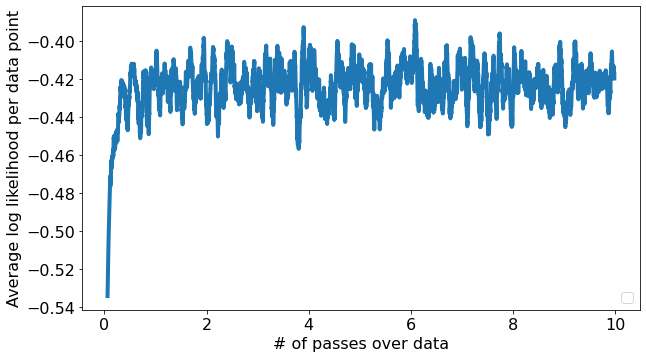

step_size = 10.0
Iteration    0: Average log likelihood (of data points  [00000:00100]) = -0.51319004
Iteration    1: Average log likelihood (of data points  [00100:00200]) = -2.20035379
Iteration    2: Average log likelihood (of data points  [00200:00300]) = -3.34199720
Iteration    3: Average log likelihood (of data points  [00300:00400]) = -3.06285156
Iteration    4: Average log likelihood (of data points  [00400:00500]) = -2.80822162
Iteration    5: Average log likelihood (of data points  [00500:00600]) = -2.99629286
Iteration    6: Average log likelihood (of data points  [00600:00700]) = -2.71489944
Iteration    7: Average log likelihood (of data points  [00700:00800]) = -3.61713200
Iteration    8: Average log likelihood (of data points  [00800:00900]) = -1.19526584
Iteration    9: Average log likelihood (of data points  [00900:01000]) = -0.75357081
Iteration   10: Average log likelihood (of data points  [01000:01100]) = -0.71310829
Iteration   11: Average log likelihood (of data 

No handles with labels found to put in legend.


Iteration 4769: Average log likelihood (of data points  [47600:47700]) = -2.48776279


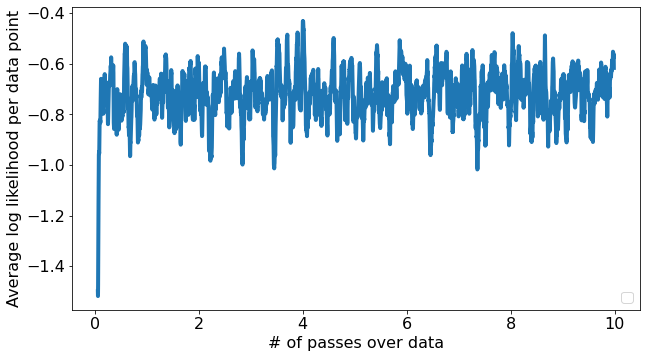

step_size = 100.0
Iteration    0: Average log likelihood (of data points  [00000:00100]) = -2.44471310
Iteration    1: Average log likelihood (of data points  [00100:00200]) = -36.66862050
Iteration    2: Average log likelihood (of data points  [00200:00300]) = -25.49870239
Iteration    3: Average log likelihood (of data points  [00300:00400]) = -40.14565040
Iteration    4: Average log likelihood (of data points  [00400:00500]) = -27.03748522
Iteration    5: Average log likelihood (of data points  [00500:00600]) = -32.62294582
Iteration    6: Average log likelihood (of data points  [00600:00700]) = -25.88017915
Iteration    7: Average log likelihood (of data points  [00700:00800]) = -37.30720216
Iteration    8: Average log likelihood (of data points  [00800:00900]) = -10.87360529
Iteration    9: Average log likelihood (of data points  [00900:01000]) = -6.60878996
Iteration   10: Average log likelihood (of data points  [01000:01100]) = -7.15375088
Iteration   11: Average log likelihood 

/Users/kevinwang/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in exp
  """


Iteration  100: Average log likelihood (of data points  [10000:10100]) = -10.64501704
Iteration  200: Average log likelihood (of data points  [20000:20100]) = -4.03623066


/Users/kevinwang/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: overflow encountered in exp
  if sys.path[0] == '':


Iteration  300: Average log likelihood (of data points  [30000:30100]) = -9.16598260
Iteration  400: Average log likelihood (of data points  [40000:40100]) = -6.53500674
Iteration  500: Average log likelihood (of data points  [02300:02400]) = -5.74111518
Iteration  600: Average log likelihood (of data points  [12300:12400]) = -12.39788107
Iteration  700: Average log likelihood (of data points  [22300:22400]) = -8.73851801
Iteration  800: Average log likelihood (of data points  [32300:32400]) = -9.20873511
Iteration  900: Average log likelihood (of data points  [42300:42400]) = -4.19929473
Iteration 1000: Average log likelihood (of data points  [04600:04700]) = -3.42817101
Iteration 2000: Average log likelihood (of data points  [09200:09300]) = -17.67154169
Iteration 3000: Average log likelihood (of data points  [13800:13900]) = -2.10596986
Iteration 4000: Average log likelihood (of data points  [18400:18500]) = -28.68013706


No handles with labels found to put in legend.


Iteration 4769: Average log likelihood (of data points  [47600:47700]) = -26.48568664


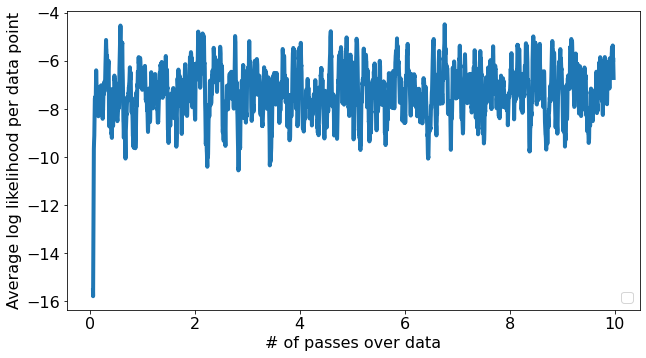

In [71]:
step_size_list = [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2]

for i in step_size_list:
    print('step_size = ' + str(i))
    coefficients_mini_batch3, log_likelihood_mini_batch3 = logistic_regression_SG(feature_matrix, sentiment, initial_coefficients=np.zeros(194), step_size=i, batch_size=100, max_iter=max_iter)
    make_plot(log_likelihood_mini_batch3, len(feature_matrix_train), batch_size, smoothing_window=30, label='')

Quiz Question: Which of the following is the worst step size? Pick the step size that results in the lowest log likelihood in the end.

answer: step size = 1e2

Quiz Question: Which of the following is the best step size? Pick the step size that results in the highest log likelihood in the end.

answer: step size = 1